In [2]:
import torch
import torch.nn as nn
import torch
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from PIL import Image
import os
import zipfile

In [3]:
path = "C:\\Users\\user\\Desktop\\Python2\\Lab2\\set\\dataset.csv"
dframe = pd.read_csv(
    path, delimiter=",", names=["Absolute path", "Relative path", "Class"]
)
img_list = dframe["Absolute path"].tolist()
random.shuffle(img_list)
print(img_list[:7]) 

['C:\\Users\\user\\Desktop\\Python2\\dataset\\cat\\0256.jpg', 'C:\\Users\\user\\Desktop\\Python2\\dataset\\dog\\0898.jpg', 'C:\\Users\\user\\Desktop\\Python2\\dataset\\dog\\0385.jpg', 'C:\\Users\\user\\Desktop\\Python2\\dataset\\cat\\0748.jpg', 'C:\\Users\\user\\Desktop\\Python2\\dataset\\cat\\0547.jpg', 'C:\\Users\\user\\Desktop\\Python2\\dataset\\cat\\0379.jpg', 'C:\\Users\\user\\Desktop\\Python2\\dataset\\cat\\0356.jpg']


In [4]:
img_label=[]
for i in range(len(img_list)):
    img_label.append(os.path.basename(os.path.dirname(img_list[i])))
print(img_label[:5])

['cat', 'dog', 'dog', 'cat', 'cat']


In [5]:
training_list = img_list[0 : int(len(img_list) * 0.8)]
testing_list = img_list[int(len(img_list) * 0.8) : int(len(img_list) * 0.9)]
validation_list = img_list[int(len(img_list) * 0.9) : int(len(img_list))] 
print(len(training_list ), len(testing_list), len(validation_list))

1612 202 202


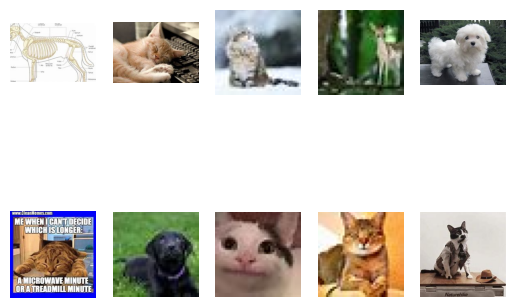

In [14]:
random_idx = np.random.randint(1,len(img_list),size=10)
fig = plt.figure()
i=1
for idx in random_idx:
    ax = fig.add_subplot(2,5,i) 
    img = Image.open(img_list[idx])
    plt.imshow(img)
    i+=1
    plt.axis('off') 
plt.show()

In [15]:
class dataset(torch.utils.data.Dataset):  
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform

    # dataset length
    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength

    # load an one of images
    def __getitem__(self, idx):
        img_label = []
        for i in range(len(self.file_list)):
            img_label.append(os.path.basename(
                os.path.dirname(self.file_list[i])))
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)
        label = img_label[idx]
        if label == "cat":
            label = 0
        elif label == "dog":
            label = 1
        return img_transformed, label

In [16]:
transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)
train_data = dataset(training_list, transform=transform)
test_data = dataset(testing_list, transform=transform)
val_data = dataset(validation_list, transform=transform)
print(len(train_data), len(test_data), len(val_data))
train_data[0][0].shape

1612 202 202


torch.Size([3, 224, 224])

In [18]:
class Cnn(nn.Module):
    '''класс построения сверточной модели'''

    def __init__(self):
        super(Cnn, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.fc1 = nn.Linear(3 * 3 * 64, 10)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(10, 2)
        self.relu = nn.ReLU()

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0), -1)
        out = self.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [19]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(1234)
if device =='cuda':
    torch.cuda.manual_seed_all(1234)
model = Cnn()
optimizer = optim.Adam(params = model.parameters(),lr=0.001)
criterion = nn.CrossEntropyLoss()
model.train()

Cnn(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=576, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=10, out_features=2, bias=True)
  (re

In [20]:
def show_results(epochs, acc, loss, val_acc, val_loss) -> None: 
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    ax[0].plot(range(epochs), acc, color="green", label="Train")
    ax[1].plot(range(epochs), loss, color="green", label="Train")
    ax[0].plot(range(epochs), val_acc, color="crimson", label="Validation")
    ax[1].plot(range(epochs), val_loss, color="crimson", label="Validation")
    ax[0].set_title('Accuracy')
    ax[1].set_title('Loss')
    ax[0].legend()
    ax[1].legend()
    fig.suptitle('The result of the training')
    plt.show()

In [ ]:
cat_probs = []
model.eval()
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size=100, shuffle=False)
with torch.no_grad():
    for data, fileid in test_loader:
        data = data.to(device)
        preds = model(data)
        preds_list = F.softmax(preds, dim=1)[:, 1].tolist()
        cat_probs += list(zip(list(fileid), preds_list))
cat_probs.sort(key = lambda x : int(x[0]))
cat_probs[:10]

In [24]:
id = list(i for i in range(len(cat_probs)))
label = list(map(lambda x: x[1], cat_probs))
submission = pd.DataFrame({'id':id, 'label':label})
submission.to_csv('final.csv', index=False)
submission

,id,label
0,0,0.460523
1,1,0.458122
2,2,0.461230
3,3,0.459906
4,4,0.461168
...,...,...
95,95,0.459259
96,96,0.461917
97,97,0.457173
98,98,0.462233


In [25]:
id = list(i for i in range(len(cat_probs)))
label = list(map(lambda x: x[1], cat_probs))
print({"id": id, "label": label})

{'id': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99], 'label': [0.46052345633506775, 0.458122193813324, 0.4612300992012024, 0.4599059522151947, 0.46116793155670166, 0.4611210525035858, 0.45931750535964966, 0.45881515741348267, 0.45579883456230164, 0.4578208327293396, 0.4557253122329712, 0.4584459960460663, 0.45931655168533325, 0.45788663625717163, 0.4614722728729248, 0.46069270372390747, 0.45895904302597046, 0.46175849437713623, 0.45938047766685486, 0.4577029049396515, 0.4561493694782257, 0.46120235323905945, 0.4581025540828705, 0.45591190457344055, 0.4592706859111786, 0.46117573976516724, 0.46017202734947205, 0.4588388204574585, 0.462500303983688